# 量化策略回测框架 (单向持仓版本 - 修正版)

In [6]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path
import warnings
from collections import deque

warnings.filterwarnings('ignore', category=FutureWarning)

---
## 1. 日志和绘图设置

In [7]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数

In [ ]:
def run_single_direction_backtest(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    执行单向持仓策略的回测, 资金等分成10份, 避免重复计算手续费
    收到反向信号时只平掉最早的一份持仓, 而不是全部平仓!
    
    核心逻辑:
    1. 初始资金分成10等份, 每份独立管理
    2. 在任何时刻只能持有一个方向的仓位（全多头或全空头）
    3. 信号在t时刻产生, 在t+1时刻执行
    4. 当收到相反方向的信号时, 只平掉最早的一份持仓
    5. 每份仓位最多持有holding_period个周期, 到期自动平仓
    
    参数:
    - prices (pd.Series): 'close'价格序列
    - signals (pd.Series): 交易信号序列 (1 for long, -1 for short, 0 for neutral)
    - initial_capital (float): 初始资金
    - commission_rate (float): 单边交易手续费率
    - holding_period (int): 每笔交易的固定持有周期
    
    返回:
    - pd.DataFrame: 包含回测详细过程的DataFrame
    """
    logging.info("🤔 开始执行单向持仓策略回测 (修正版: 反向信号只平掉最早持仓)...")
    
    # 复制数据以避免修改原始数据
    df = pd.DataFrame({
        'close': prices,
        'signal': signals
    }).copy()
    
    # 初始化结果列
    df['position'] = 0.0                  # 当前持仓方向 (1: 多, -1: 空, 0: 无)
    df['position_count'] = 0              # 当前持仓份数
    df['cost_basis'] = 0.0                # 当前持仓成本价
    df['strategy_returns'] = 0.0          # 策略收益
    df['transaction_costs'] = 0.0         # 交易成本
    df['net_returns'] = 0.0               # 净收益
    df['cumulative_returns'] = 0.0        # 累计收益
    df['equity_curve'] = initial_capital  # 资金曲线
    
    # 初始化持仓管理
    active_positions = deque()  # 使用deque作为先进先出队列
    realized_pnl = 0.0          # 已实现盈亏
    cumulative_pnl = 0.0        # 累计盈亏
    position_direction = 0      # 当前持仓方向
    position_cost = 0.0         # 当前持仓平均成本
    
    # 资金分成10份
    capital_per_position = initial_capital / 10
    
    # 遍历每个时间点
    for i in range(1, len(df)):
        current_close = df['close'].iloc[i]
        prev_signal = df['signal'].iloc[i-1]  # 使用前一个信号决定当前操作
        
        # 1. 处理到期仓位
        positions_to_remove = []
        for pos in list(active_positions):  # 使用list避免在遍历时修改队列
            # 检查仓位是否到期
            if i - pos['entry_index'] >= holding_period:
                # 计算盈亏
                exit_price = current_close
                direction = pos['direction']
                quantity = pos['quantity']
                entry_price = pos['entry_price']
                
                # 计算盈亏和手续费
                pnl = (exit_price - entry_price) * direction * quantity
                exit_commission = commission_rate * exit_price * quantity
                net_pnl = pnl - exit_commission
                
                # 更新累计盈亏
                realized_pnl += net_pnl
                cumulative_pnl += net_pnl
                
                # 记录交易成本
                df.at[df.index[i], 'transaction_costs'] += exit_commission
                
                # 标记为需要移除
                positions_to_remove.append(pos)
        
        # 移除到期仓位
        for pos in positions_to_remove:
            active_positions.remove(pos)
        
        # 2. 处理新信号
        if prev_signal != 0:  # 忽略中性信号
            # 情况1: 当前无持仓
            if position_direction == 0:
                # 开新仓
                entry_price = current_close
                quantity = capital_per_position / entry_price
                
                new_position = {
                    'direction': prev_signal,
                    'entry_price': entry_price,
                    'quantity': quantity,
                    'entry_index': i
                }
                active_positions.append(new_position)
                
                # 更新持仓信息
                position_direction = prev_signal
                position_cost = entry_price
                
                # 计算开仓手续费
                entry_commission = commission_rate * entry_price * quantity
                df.at[df.index[i], 'transaction_costs'] += entry_commission
                
                # 记录仓位变化
                df.at[df.index[i], 'position'] = prev_signal
            
            # 情况2: 当前有持仓且新信号方向相同
            elif position_direction == prev_signal:
                # 检查是否还有可用仓位 (最多10份)
                if len(active_positions) < 10:
                    # 开新仓
                    entry_price = current_close
                    quantity = capital_per_position / entry_price
                    
                    new_position = {
                        'direction': prev_signal,
                        'entry_price': entry_price,
                        'quantity': quantity,
                        'entry_index': i
                    }
                    active_positions.append(new_position)
                    
                    # 更新平均成本
                    total_quantity = sum(pos['quantity'] for pos in active_positions)
                    position_cost = sum(pos['entry_price'] * pos['quantity'] for pos in active_positions) / total_quantity
                    
                    # 计算开仓手续费
                    entry_commission = commission_rate * entry_price * quantity
                    df.at[df.index[i], 'transaction_costs'] += entry_commission
                    
                    # 记录仓位变化
                    df.at[df.index[i], 'position'] = prev_signal
            
            # 情况3: 当前有持仓且新信号方向相反
            else:
                # 只平掉最早的一份持仓
                if active_positions:
                    # 获取最早的开仓
                    oldest_position = active_positions.popleft()
                    
                    # 平仓操作
                    exit_price = current_close
                    direction = oldest_position['direction']
                    quantity = oldest_position['quantity']
                    entry_price = oldest_position['entry_price']
                    
                    # 计算盈亏和手续费
                    pnl = (exit_price - entry_price) * direction * quantity
                    exit_commission = commission_rate * exit_price * quantity
                    net_pnl = pnl - exit_commission
                    
                    # 更新累计盈亏
                    realized_pnl += net_pnl
                    cumulative_pnl += net_pnl
                    
                    # 记录交易成本
                    df.at[df.index[i], 'transaction_costs'] += exit_commission
                    
                    # 检查是否还有剩余持仓
                    if active_positions:
                        # 更新平均成本
                        total_quantity = sum(pos['quantity'] for pos in active_positions)
                        position_cost = sum(pos['entry_price'] * pos['quantity'] for pos in active_positions) / total_quantity
                    else:
                        # 没有持仓了
                        position_direction = 0
                        position_cost = 0.0
                    
                    # 记录仓位变化
                    df.at[df.index[i], 'position'] = position_direction
        
        # 更新当前持仓状态
        df.at[df.index[i], 'position_count'] = len(active_positions)
        df.at[df.index[i], 'cost_basis'] = position_cost
        
        # 计算当日浮动盈亏 (仅用于记录)
        unrealized_pnl = 0.0
        for pos in active_positions:
            current_price = df['close'].iloc[i]
            direction = pos['direction']
            quantity = pos['quantity']
            entry_price = pos['entry_price']
            unrealized_pnl += (current_price - entry_price) * direction * quantity
        
        # 总收益 = 已实现盈亏 + 未实现盈亏
        total_pnl = realized_pnl + unrealized_pnl
        
        # 计算当日净收益 (已实现部分)
        if i > 1:
            prev_equity = df.at[df.index[i-1], 'equity_curve']
            current_equity = initial_capital + total_pnl
            df.at[df.index[i], 'equity_curve'] = current_equity
            df.at[df.index[i], 'net_returns'] = (current_equity - prev_equity) / prev_equity
        else:
            current_equity = initial_capital + total_pnl
            df.at[df.index[i], 'equity_curve'] = current_equity
            df.at[df.index[i], 'net_returns'] = (current_equity - initial_capital) / initial_capital
        
        # 更新累计收益
        df.at[df.index[i], 'cumulative_returns'] = total_pnl
    
    # 处理回测结束时的未平仓仓位
    if active_positions:
        last_close = df['close'].iloc[-1]
        for pos in active_positions:
            exit_price = last_close
            direction = pos['direction']
            quantity = pos['quantity']
            entry_price = pos['entry_price']
            
            # 计算盈亏和手续费
            pnl = (exit_price - entry_price) * direction * quantity
            exit_commission = commission_rate * exit_price * quantity
            net_pnl = pnl - exit_commission
            
            # 更新累计盈亏
            cumulative_pnl += net_pnl
            
            # 记录交易成本
            df.at[df.index[-1], 'transaction_costs'] += exit_commission
        
        # 更新最终资金曲线
        df.at[df.index[-1], 'equity_curve'] = initial_capital + cumulative_pnl
        prev_equity = df.at[df.index[-2], 'equity_curve'] if len(df) > 1 else initial_capital
        df.at[df.index[-1], 'net_returns'] = (df.at[df.index[-1], 'equity_curve'] - prev_equity) / prev_equity
    
    logging.info("🎉 单向持仓策略回测完成 (修正版)")
    return df

In [9]:
def evaluate_single_direction_performance(backtest_results, initial_capital):
    """
    评估单向持仓策略的表现
    """
    logging.info("🤔 开始评估单向持仓策略表现...")
    
    # 提取结果
    df = backtest_results.copy()
    
    # 计算关键指标
    total_return = (df['equity_curve'].iloc[-1] - initial_capital) / initial_capital
    
    # 计算回撤
    equity_curve = df['equity_curve']
    peak = equity_curve.cummax()
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max()
    
    # 计算策略收益率
    strategy_returns = df['net_returns']
    
    # 计算年化收益率
    total_days = (df.index[-1] - df.index[0]).days
    annualized_return = total_return / (total_days / 365.25) if total_days > 0 else 0
    
    # 计算波动率 (年化)
    daily_volatility = strategy_returns.std()
    annualized_volatility = daily_volatility * np.sqrt(365.25 * 24 * 4)  # 15分钟数据
    
    # 计算夏普比率 (无风险利率设为0)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
    
    # 计算卡玛比率
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # 计算与理论基准的相关性
    theoretical_benchmark = (df['signal'].shift(1) * df['close'].pct_change().fillna(0)).cumsum()
    strategy_cumulative = (df['equity_curve'] - initial_capital) / initial_capital
    correlation = strategy_cumulative.corr(theoretical_benchmark)
    
    # 打印报告
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 20 + "单向持仓策略性能评估报告" + " " * 20 + Style.RESET_ALL)
    print("="*80)
    
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["总收益率 (Total Return)", f"{total_return:.2%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.2%}"],
        ["年化波动率 (Annualized Volatility)", f"{annualized_volatility:.2%}"],
        ["夏普比率 (Sharpe Ratio)", f"{sharpe_ratio:.4f}"],
        ["最大回撤 (Max Drawdown)", f"{max_drawdown:.2%}"],
        ["卡玛比率 (Calmar Ratio)", f"{calmar_ratio:.4f}"],
        ["与理论基准的相关性", f"{correlation:.4f}"],
        ["最终资金", f"${df['equity_curve'].iloc[-1]:,.2f}"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 绘制权益曲线
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # 策略曲线
    ax.plot(df.index, df['equity_curve'], label='Strategy Equity', color='royalblue', linewidth=2)
    
    # 理论基准曲线
    theoretical_curve = initial_capital * (1 + theoretical_benchmark)
    ax.plot(df.index, theoretical_curve, label='Theoretical Benchmark (signal*return)', color='purple', linestyle='--', alpha=0.7)
    
    # 买入持有曲线
    buy_hold_curve = initial_capital * (1 + df['close'].pct_change().cumsum().fillna(0))
    ax.plot(df.index, buy_hold_curve, label='Buy & Hold', color='darkorange', linestyle=':', alpha=0.7)

    # 设置标题和标签
    ax.set_title('Strategy Equity Curve', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Asset Value', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

---
## 3. 主程序执行

2025-07-25 14:03:45,763 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-25 14:03:45,774 - INFO - 数据加载成功。
2025-07-25 14:03:45,776 - INFO - 🤔 开始执行单向持仓策略回测 (修正版: 反向信号只平掉最早持仓)...


数据预览:
                     signal     close
open_time                            
2021-09-27 00:00:00       0  43050.80
2021-09-27 00:15:00       0  43048.11
2021-09-27 00:30:00       0  43431.49
2021-09-27 00:45:00       0  43851.20
2021-09-27 01:00:00       0  43912.15

数据时间范围: 2021-09-27 00:00:00 -> 2025-06-30 23:45:00
数据形状: (131808, 2)


2025-07-25 14:04:18,326 - INFO - 🎉 单向持仓策略回测完成 (修正版)
2025-07-25 14:04:18,327 - INFO - 回测结果 DataFrame (前5行):
2025-07-25 14:04:18,330 - INFO - 回测结果 DataFrame (后5行):
2025-07-25 14:04:18,333 - INFO - 🤔 开始评估单向持仓策略表现...


                        close  signal  position  position_count  cost_basis  \
open_time                                                                     
2021-09-27 00:00:00  43050.80       0       0.0               0         0.0   
2021-09-27 00:15:00  43048.11       0       0.0               0         0.0   
2021-09-27 00:30:00  43431.49       0       0.0               0         0.0   
2021-09-27 00:45:00  43851.20       0       0.0               0         0.0   
2021-09-27 01:00:00  43912.15       0       0.0               0         0.0   

                     strategy_returns  transaction_costs  net_returns  \
open_time                                                               
2021-09-27 00:00:00               0.0                0.0          0.0   
2021-09-27 00:15:00               0.0                0.0          0.0   
2021-09-27 00:30:00               0.0                0.0          0.0   
2021-09-27 00:45:00               0.0                0.0          0.0   
2021-09-

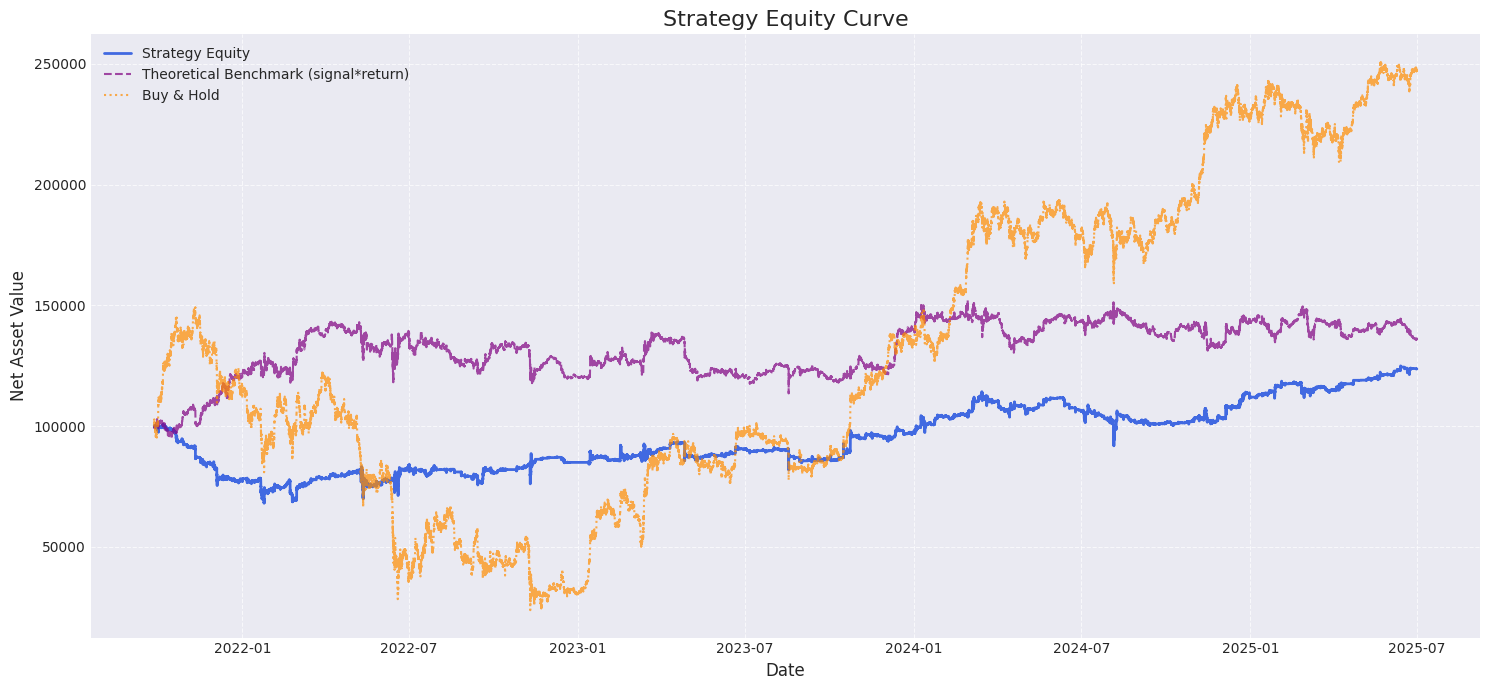

In [ ]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    # 文件路径
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    
    # 回测参数
    COMMISSION_RATE = 0.0002     # 单边手续费
    INITIAL_CAPITAL = 100000     # 初始资金
    HOLDING_PERIOD = 10          # 固定持有10个15分钟bar
    
    # --- 2. 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    
    try:
        file_path = Path(FILE_PATH)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # 确保索引是datetime类型
        data.index = pd.to_datetime(data.index)
        data = data.rename_axis('open_time')

        logging.info("数据加载成功。")
        print("数据预览:")
        print(data.head())
        print(f"\n数据时间范围: {data.index.min()} -> {data.index.max()}")
        print(f"数据形状: {data.shape}")

    except FileNotFoundError:
        logging.error(f"错误: 数据文件未找到于路径 {FILE_PATH}")
        data = None
    except Exception as e:
        logging.error(f"加载数据时发生错误: {e}")
        data = None

    # --- 3. 执行回测 (使用单向持仓策略) ---
    if data is not None:
        backtest_results = run_single_direction_backtest(
            prices=data['close'],
            signals=data['signal'],
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE,
            holding_period=HOLDING_PERIOD
        )
        
        logging.info("回测结果 DataFrame (前5行):")
        print(backtest_results.head())
        
        logging.info("回测结果 DataFrame (后5行):")
        print(backtest_results.tail())

        # --- 4. 性能评估 ---
        evaluate_single_direction_performance(
            backtest_results, 
            INITIAL_CAPITAL
        )
    else:
        logging.warning("由于数据加载失败, 回测和评估步骤已跳过。")